## Calculating the deviations due to a binary lens at a specific coordinate origin
#### To minimize deviations at low magnfications, try:
$\xi \rightarrow \xi + \dfrac{q}{(1+q)(s+s^{-1})}$

#### Importing libraries

In [65]:
%load_ext autoreload
%autoreload 2

import pickle
import time as t
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

init_time = t.time()
from IRSMicroLensing import IRSCaustics as IRSC
from IRSMicroLensing import IRSFunctions as IRSF
print(f'Custom library import time: {(t.time() - init_time):.3} seconds')

import VBMicrolensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Custom library import time: 0.000106 seconds


#### Defining and initializing VBMicrolensing

In [66]:
VBM = VBMicrolensing.VBMicrolensing()

# Set relative accuracy
VBM.RelTol = 1e-03

# Set accuracy
VBM.Tol=1e-03

#### Defining lens parameters

In [ ]:
''' Preparing lens parameters '''
# Big planet parameters
s1 = 0.8
alpha1 = 0
q1 = 1e-3

# Small planet parameters
s2 = 0.8
alpha2 = 30
q2 = 1e-3 * q1

# Triple lens attributes
triple_lens_attributes = [
    [0, 0, 1],
    [s1*np.cos(np.deg2rad(alpha1)), s1*np.sin(np.deg2rad(alpha1)), q1],
    [s2*np.cos(np.deg2rad(alpha2)), s2*np.sin(np.deg2rad(alpha2)), q2]
]

# Rotation matrix for first planet
first_planet_DCM = np.array([
    [np.cos(np.deg2rad(alpha1)), -np.sin(np.deg2rad(alpha1))],
    [np.sin(np.deg2rad(alpha1)), np.cos(np.deg2rad(alpha1))]
])

# Rotation matrix for second planet
second_planet_DCM = np.array([
    [np.cos(np.deg2rad(alpha2)), -np.sin(np.deg2rad(alpha2))],
    [np.sin(np.deg2rad(alpha2)), np.cos(np.deg2rad(alpha2))]
])

In [45]:
# Calculating translation of coordinate origin for each planet
q1 = triple_lens_attributes[1][2]
q2 = triple_lens_attributes[2][2]

delta1_rot = np.array([q1 / ((1 + q1) * (s1 + 1/s1)), 0]).reshape(-1, 1)
delta2_rot = np.array([q2 / ((1 + q2) * (s2 + 1/s2)), 0]).reshape(-1, 1)

delta1 = np.dot(first_planet_DCM, delta1_rot).reshape(2)
delta2 = np.dot(second_planet_DCM, delta2_rot).reshape(2)

print(delta1)
print(delta2)

total_offset = (q1*delta1 + q2*delta2)/(q1 + q2)
print(total_offset)

[0.00048732 0.        ]
[4.22450994e-07 2.43902195e-07]
[4.86831152e-04 2.43658537e-10]


In [46]:
# Defining single lens attributes
single_lens_attributes = [
    [total_offset[0], total_offset[1], 1]
]

# Defining binary lens attributes
binary_lens_attributes = [
    [total_offset[0], total_offset[1], 1],
    [s1*np.cos(np.deg2rad(alpha1)) + total_offset[0], s1*np.sin(np.deg2rad(alpha1)) + total_offset[1], q1],
]

# Annulus parameters
num_theta = 5000
num_r = 4 * num_theta

ang_width, thickness, (y_plus, y_minus), cusp_points = IRSC.IRSCaustics.ang_width_thickness_calculator(triple_lens_attributes)

print(f'Angular width: {ang_width}')
print(f'Thickness: {thickness}')
print(f'Annulus lower bound: {y_plus}')
print(f'Annulus upper bound: {y_minus}')

single_lens_parameters = {
    'pixels': 1000,
    'ang_width': ang_width,
    'thickness': thickness,
    'y_plus': y_plus,
    'y_minus': y_minus,
    'lens_att': single_lens_attributes,
    'num_theta': num_theta,
    'num_r': num_r
}

binary_lens_parameters = single_lens_parameters.copy()
binary_lens_parameters.update({
    'lens_att': binary_lens_attributes
})

triple_lens_parameters = single_lens_parameters.copy()
triple_lens_parameters.update({
    'lens_att': triple_lens_attributes
})

print(f'Number of rays: {(num_r * num_theta):.4e}')
print('=========================================================')

Angular width: 0.07680319680319682
Thickness: 0.059738867403980045
Annulus lower bound: 1.030315425782361
Annulus upper bound: -0.970576558378381
Number of rays: 1.0000e+08


In [47]:
''' Simulating single lens magnification map '''
single_lens = IRSC.IRSCaustics(annulus_param_dict=single_lens_parameters)
single_lens_magnifications = single_lens.series_calculate(cm_offset='auto')

print('=========================================================')

100%|██████████| 500/500 [00:04<00:00, 118.04it/s]


---------------------
Total time: 4.25 seconds


In [48]:
''' Simulating binary lens magnification map '''
binary_lens = IRSC.IRSCaustics(annulus_param_dict=binary_lens_parameters)
binary_lens_magnification = binary_lens.series_calculate(cm_offset='auto')

print('=========================================================')

100%|██████████| 500/500 [00:04<00:00, 107.25it/s]

---------------------
Total time: 4.672 seconds


In [49]:
''' Simulating triple lens magnification map '''
triple_lens = IRSC.IRSCaustics(annulus_param_dict=triple_lens_parameters)
triple_lens_magnifications = triple_lens.series_calculate(cm_offset='auto')

print('=========================================================')

100%|██████████| 500/500 [00:04<00:00, 106.39it/s]

---------------------
Total time: 4.711 seconds


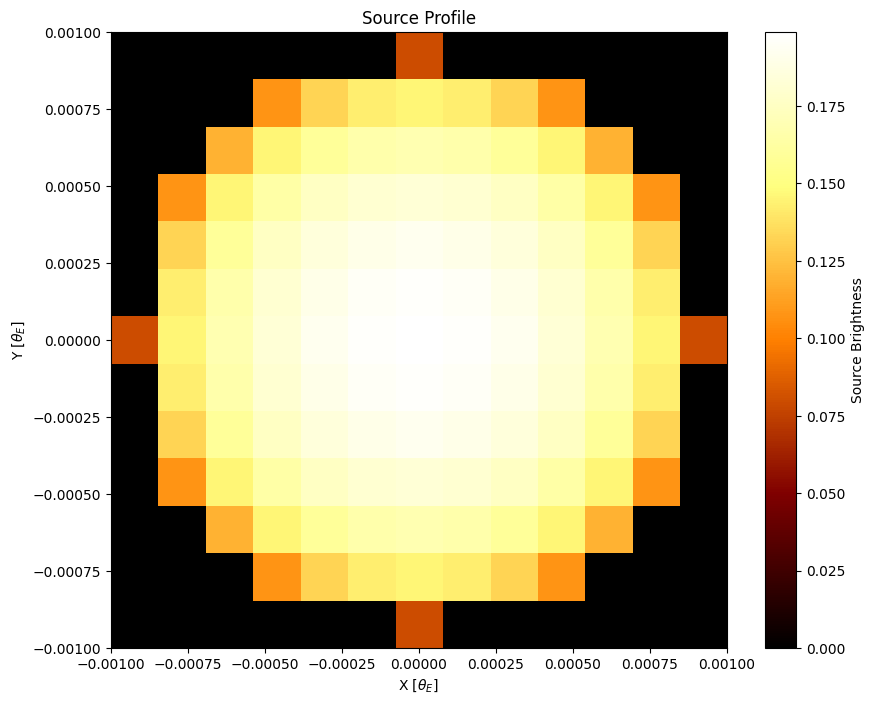

In [53]:
radius = 1e-3
LD = 0.5

source_profile = IRSF.IRSFunctions.source_profile(ang_res=single_lens.param_dict['ang_res'], rad=radius, profile_type='LD', LD=LD)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

img = ax.imshow(source_profile, cmap='afmhot', extent=[-radius, radius, -radius, radius])
plt.colorbar(img, ax=ax, label='Source Brightness')

ax.set_xlabel('X [$\\theta_E$]')
ax.set_ylabel('Y [$\\theta_E$]')
ax.set_title('Source Profile')

ax.set_aspect('equal')

plt.show()

Convolving source profile with magnification map: 0.06 seconds
Convolving source profile with magnification map: 0.025 seconds
Convolving source profile with magnification map: 0.023 seconds


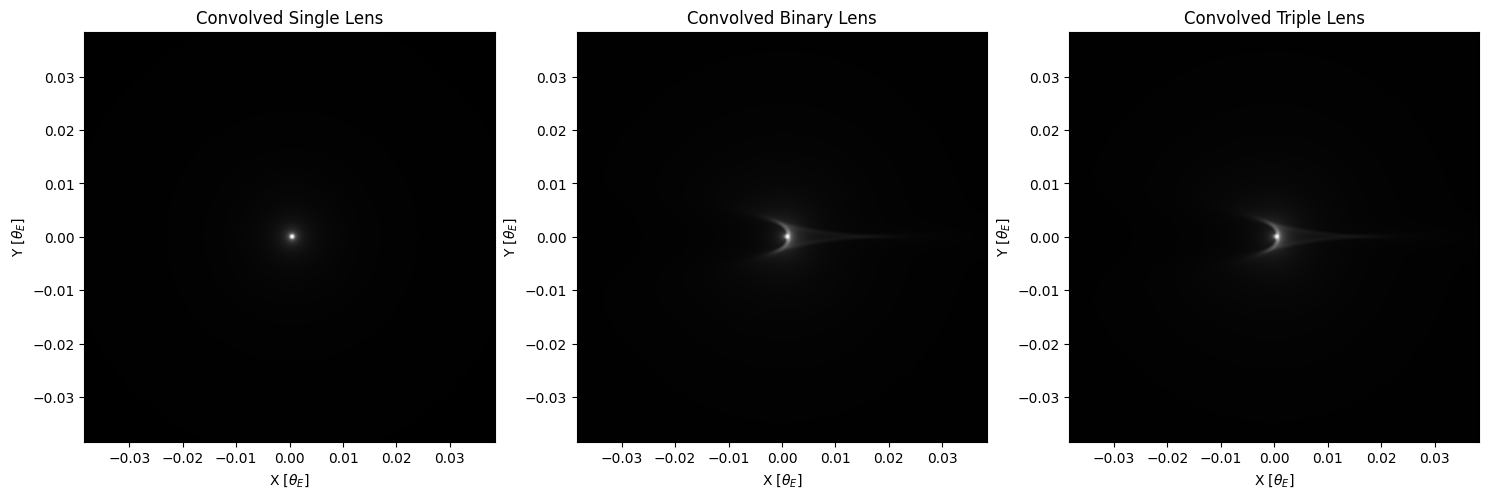

In [55]:
convolved_single_lens = single_lens.convolve(source_profile=source_profile)
convolved_binary_lens = binary_lens.convolve(source_profile=source_profile)
convolved_triple_lens = triple_lens.convolve(source_profile=source_profile)

fig = plt.figure(figsize=(18, 6))
axes = fig.subplots(1, 3)

for i, ax in enumerate(axes):
    if i == 0:
        brightnesses = convolved_single_lens
        ax.set_title(f'Convolved Single Lens')
    elif i == 1:
        brightnesses = convolved_binary_lens
        ax.set_title(f'Convolved Binary Lens')
    elif i == 2:
        brightnesses = convolved_triple_lens
        ax.set_title(f'Convolved Triple Lens')

    ax.imshow(brightnesses, cmap='gray', extent=[-single_lens.ang_width/2, single_lens.ang_width/2, -single_lens.ang_width/2, single_lens.ang_width/2])

    ax.set_xlabel('X [$\\theta_E$]')
    ax.set_ylabel('Y [$\\theta_E$]')
    ax.set_aspect('equal')

plt.show()

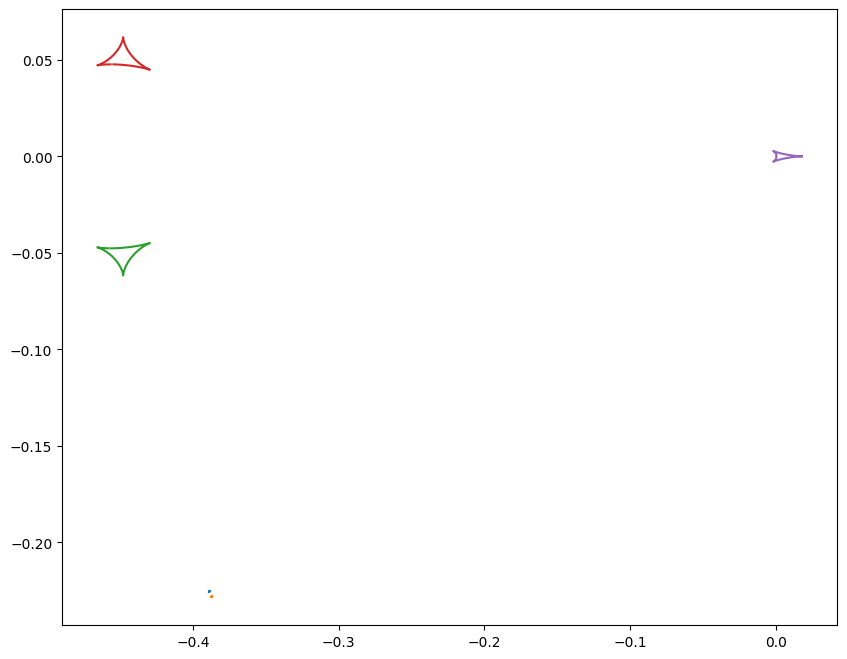

In [69]:
parameters = [item for sublist in triple_lens.lens_att for idx, item in enumerate(sublist)]
VBM.SetLensGeometry(parameters)

caustic_points = VBM.Multicaustics()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

all_cusp_xs = []
all_cusp_ys = []

for points in caustic_points:
    ax.plot(points[0], points[1])
    xs, ys = IRSF.IRSFunctions.find_cusp_points(np.array(points))
    all_cusp_xs.append(xs)
    all_cusp_ys.append(ys)

all_cusp_xs = np.array(all_cusp_xs)
all_cusp_ys = np.array(all_cusp_ys)

all_cusp_distances = np.sqrt(all_cusp_xs**2 + all_cusp_ys**2)
min_indices = np.unravel_index(np.argmin(all_cusp_distances), all_cusp_distances.shape)

plt.show()

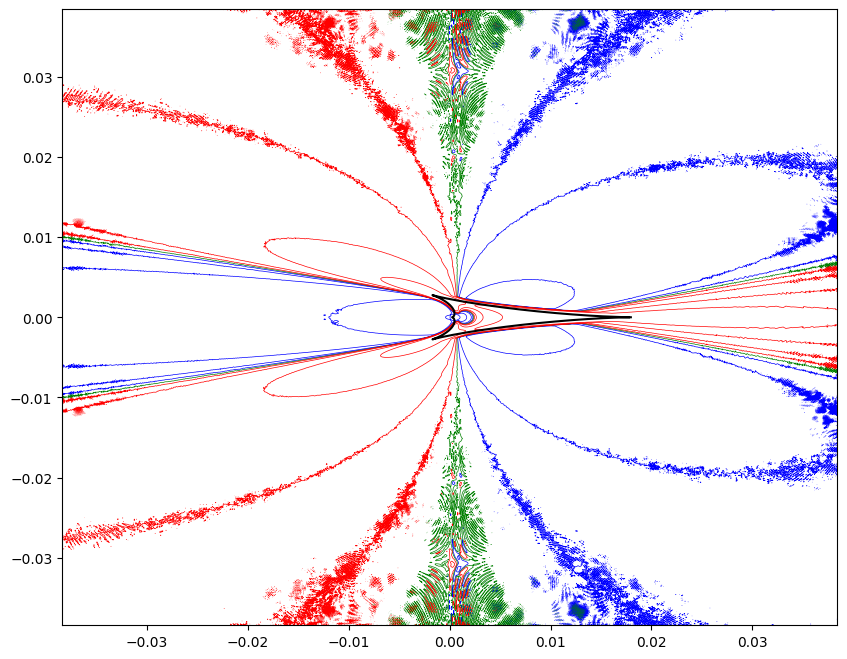

In [70]:
single_fractional_deviations = (convolved_triple_lens - convolved_single_lens) / convolved_single_lens

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

img = ax.contour(single_lens.X_pix, single_lens.Y_pix, single_fractional_deviations,
                levels=[-0.30, -0.10, -0.03, -0.01, 0, 0.01, 0.03, 0.10, 0.30],
                colors=['blue', 'blue', 'blue', 'blue', 'green', 'red', 'red', 'red', 'red'],
                linewidths=0.5
)

ax.plot(caustic_points[min_indices[0]][0], caustic_points[min_indices[0]][1], color='black')

plt.show()

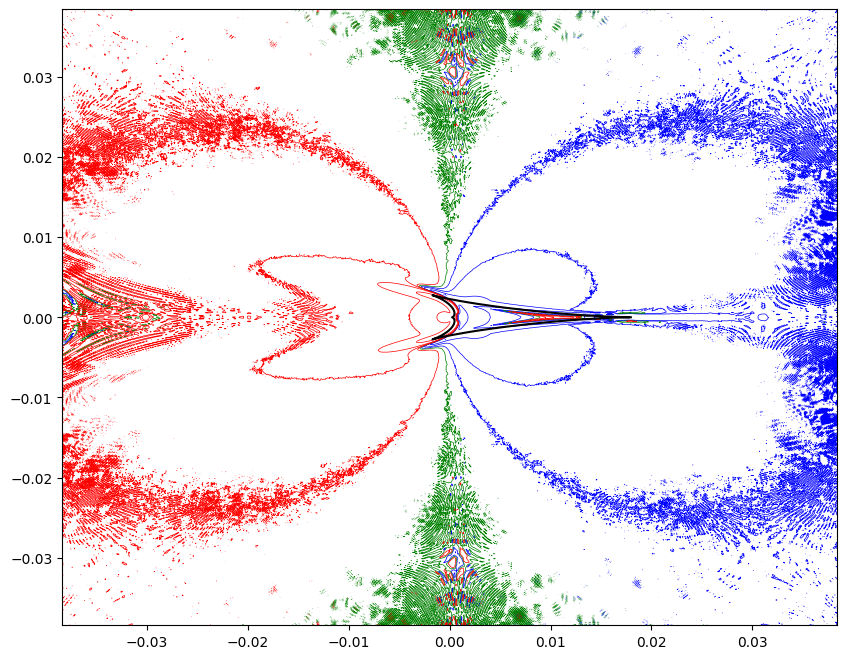

In [71]:
binary_fractional_deviations = (convolved_triple_lens - convolved_binary_lens) / convolved_binary_lens

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

img = ax.contour(single_lens.X_pix, single_lens.Y_pix, binary_fractional_deviations,
                levels=[-0.30, -0.10, -0.03, -0.01, 0, 0.01, 0.03, 0.10, 0.30],
                colors=['blue', 'blue', 'blue', 'blue', 'green', 'red', 'red', 'red', 'red'],
                linewidths=0.5
)

ax.plot(caustic_points[min_indices[0]][0], caustic_points[min_indices[0]][1], color='black')

plt.show()